# BRCA Subtype Classification Using Gene Expression
## Transfer Learning with BulkRNABert + PyTorch MLP

---

### Project Goal
Classify breast cancer (BRCA) samples into 5 molecular subtypes using:
1. **MLP Classifier** - Direct neural network on raw gene expression (19,062 genes)
2. **BulkRNABert + Classifier** - Pre-trained transformer embeddings (768 dimensions) + simple classifier

### Key Details
- **Data**: TCGA-BRCA gene expression (TPM values, log-transformed)
- **Subtypes**: BRCA_Basal, BRCA_Her2, BRCA_LumA, BRCA_LumB, BRCA_Normal
- **Hardware**: GPU with 6GB VRAM (RTX 4050)
- **Approach**: Transfer learning (use BulkRNABert's pre-trained knowledge)

### What You'll Learn
✓ Data preparation and train/test splitting  
✓ Building a PyTorch neural network from scratch  
✓ Training with early stopping and validation  
✓ Transfer learning with pre-trained transformers  
✓ Comparing different classification approaches  

---

# SECTION 1: DATA PREPARATION
## Prepare and explore TCGA-BRCA gene expression data

### Step 1.1: Extract Common Genes for BulkRNABert

BulkRNABert expects exactly 19,062 genes in a specific order (from `common_gene_id.txt`).  
We filter and reorder our data to match this requirement.

**Process:**
1. Load gene expression data (TCGA-BRCA)
2. Load the official gene list from BulkRNABert
3. Filter to keep only matching genes
4. Add zero-padding for missing genes
5. Reorder to match BulkRNABert's expected order

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Load the common gene IDs (The master list from BulkRNABert)
print("[Step 1.1] Loading gene reference data...")
with open('common_gene_id.txt', 'r') as f:
    ordered_common_genes = [line.strip() for line in f if line.strip()]

# Load TCGA-BRCA TPM data
df = pd.read_csv('BRCA-data_transformer.tsv', sep='\t', index_col=0)
print(f"Loaded data shape: {df.shape}")

# Separate subtype column
subtype_col_name = df.columns[-1]
subtypes = df[subtype_col_name]

# Filter to common genes and handle missing genes
existing_genes = [g for g in ordered_common_genes if g in df.columns]
missing_genes = [g for g in ordered_common_genes if g not in df.columns]

df_filtered = df[existing_genes]
print(f"Found {len(existing_genes)} / {len(ordered_common_genes)} genes")
print(f"Missing: {len(missing_genes)} genes (will be zero-padded)")

# Add missing genes as zeros
if missing_genes:
    zero_data = np.zeros((len(df_filtered), len(missing_genes)))
    df_zeros = pd.DataFrame(zero_data, index=df_filtered.index, columns=missing_genes)
    df_combined = pd.concat([df_filtered, df_zeros], axis=1)
else:
    df_combined = df_filtered

# Reorder to match BulkRNABert's expected gene order
df_final = df_combined[ordered_common_genes].copy()
df_final[subtype_col_name] = subtypes

# Save prepared data
df_final.to_csv('ready_for_bulkRNABert.csv')
print(f"\n✓ Data prepared: {df_final.shape[0]} samples × {len(ordered_common_genes)} genes")
print(f"Saved as 'ready_for_bulkRNABert.csv'")

[Step 1.1] Loading gene reference data...
Loaded data shape: (991, 60661)
Found 19062 / 19062 genes
Missing: 0 genes (will be zero-padded)

✓ Data prepared: 991 samples × 19062 genes
Saved as 'ready_for_bulkRNABert.csv'


### Step 1.2: Exploratory Data Analysis (EDA)

Understand the distribution of samples across subtypes and check data quality.

[Step 1.2] Exploratory Data Analysis...

DATA OVERVIEW
Total samples: 991
Total genes: 19062
Missing values: 0

Subtype Distribution:
Subtype
BRCA_Basal     176
BRCA_Her2       78
BRCA_LumA      504
BRCA_LumB      197
BRCA_Normal     36
Name: count, dtype: int64

Class balance:
Subtype
BRCA_LumA      50.86
BRCA_LumB      19.88
BRCA_Basal     17.76
BRCA_Her2       7.87
BRCA_Normal     3.63
Name: count, dtype: float64

Gene Expression Statistics (log-TPM):
  Mean: 2.9554
  Std:  2.4403
  Min:  0.0000
  Max:  17.9388


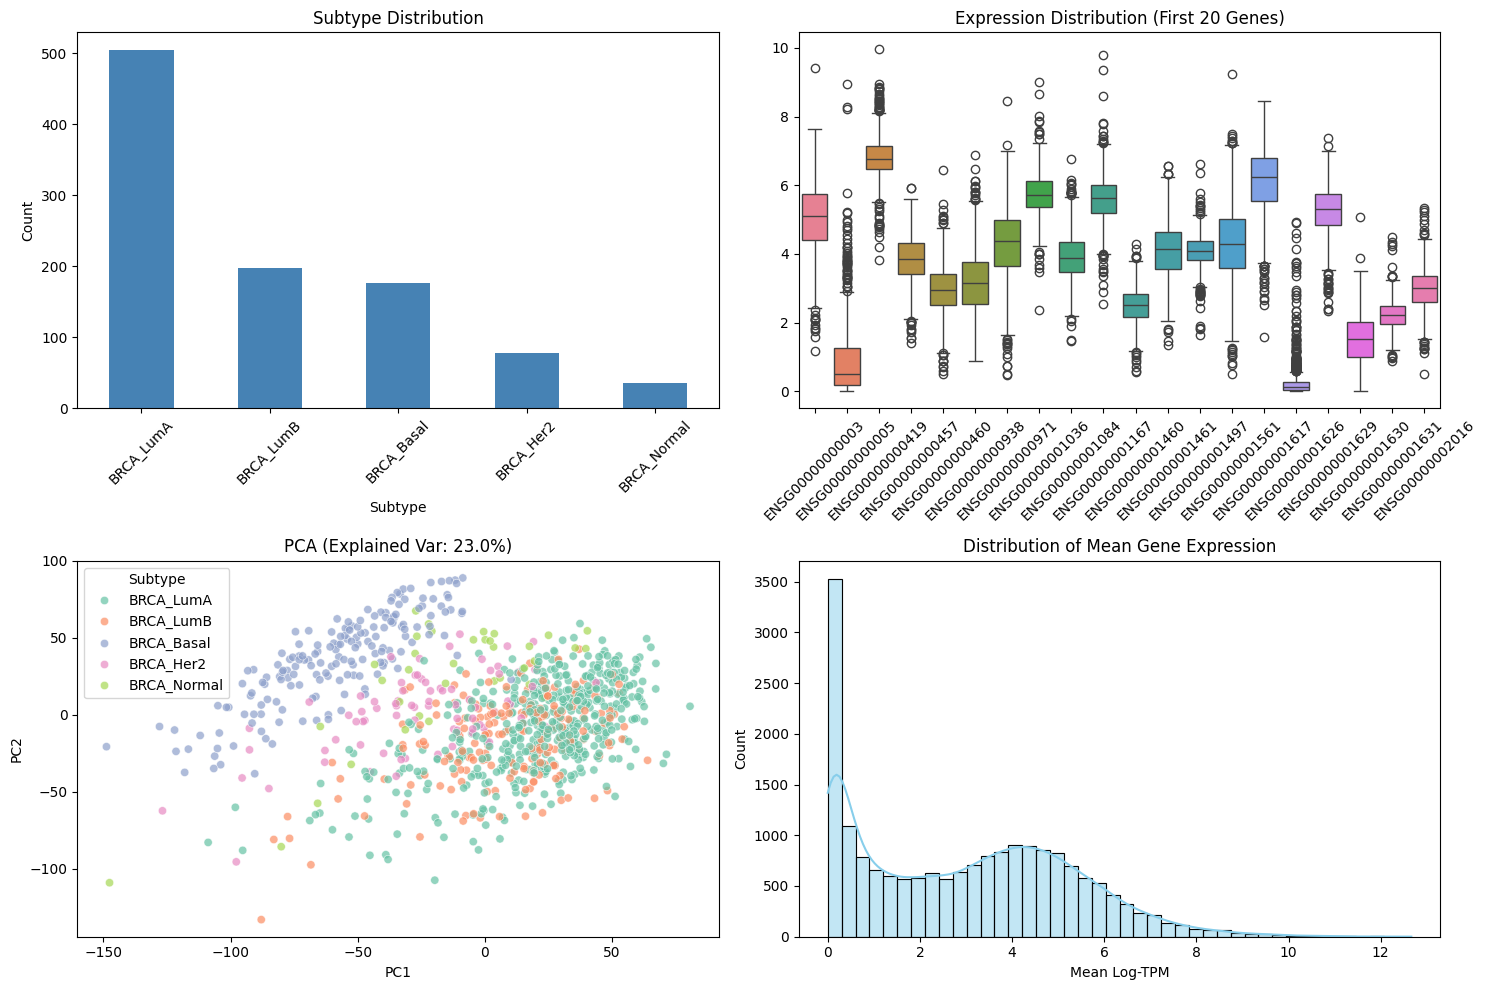


✓ EDA visualizations saved as 'eda_overview.png'


In [2]:
print("[Step 1.2] Exploratory Data Analysis...\n")

# Load prepared data
df = pd.read_csv('ready_for_bulkRNABert.csv', index_col=0)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Basic statistics
print("="*70)
print("DATA OVERVIEW")
print("="*70)
print(f"Total samples: {df.shape[0]}")
print(f"Total genes: {df.shape[1] - 1}")
print(f"Missing values: {df.isnull().sum().sum()}")

print(f"\nSubtype Distribution:")
print(y.value_counts().sort_index())
print(f"\nClass balance:")
print((y.value_counts() / len(y) * 100).round(2))

# Expression statistics
print(f"\nGene Expression Statistics (log-TPM):")
print(f"  Mean: {X.values.mean():.4f}")
print(f"  Std:  {X.values.std():.4f}")
print(f"  Min:  {X.values.min():.4f}")
print(f"  Max:  {X.values.max():.4f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Subtype distribution
y.value_counts().plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Subtype Distribution')
axes[0, 0].set_xlabel('Subtype')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Expression distribution (first 20 genes)
sns.boxplot(data=X.iloc[:, :20], ax=axes[0, 1])
axes[0, 1].set_title('Expression Distribution (First 20 Genes)')
axes[0, 1].tick_params(axis='x', rotation=45)

# PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Subtype'] = y.values
sns.scatterplot(x='PC1', y='PC2', hue='Subtype', data=pca_df, 
                palette='Set2', ax=axes[1, 0], alpha=0.7)
axes[1, 0].set_title(f'PCA (Explained Var: {pca.explained_variance_ratio_.sum():.1%})')

# Gene expression mean distribution
sns.histplot(X.mean(axis=0), kde=True, ax=axes[1, 1], color='skyblue')
axes[1, 1].set_title('Distribution of Mean Gene Expression')
axes[1, 1].set_xlabel('Mean Log-TPM')

plt.tight_layout()
plt.savefig('eda_overview.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\n✓ EDA visualizations saved as 'eda_overview.png'")

### Step 1.3: Train/Test Split

Split data into training (80%) and testing (20%) sets with stratification to preserve class ratios.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("[Step 1.3] Train/Test Split...\n")

# Extract features and labels
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,  # Keep class ratios same in train/test
    random_state=42
)

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:     {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nTraining set class distribution:")
print(y_train.value_counts().sort_index())

print(f"\nTest set class distribution:")
print(y_test.value_counts().sort_index())

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Data normalized")
print(f"  Train - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")

# Encode labels
unique_subtypes = sorted(y_train.unique())
subtype_to_idx = {st: idx for idx, st in enumerate(unique_subtypes)}
idx_to_subtype = {idx: st for st, idx in subtype_to_idx.items()}

y_train_idx = y_train.map(subtype_to_idx).values
y_test_idx = y_test.map(subtype_to_idx).values

print(f"\n✓ Labels encoded: {subtype_to_idx}")

# Save splits
import os
outdir = "splits_v1"
os.makedirs(outdir, exist_ok=True)

X_train.to_csv(f"{outdir}/X_train.csv")
X_test.to_csv(f"{outdir}/X_test.csv")
y_train.to_csv(f"{outdir}/y_train.csv", header=True)
y_test.to_csv(f"{outdir}/y_test.csv", header=True)

print(f"\n✓ Data splits saved to '{outdir}/'")

[Step 1.3] Train/Test Split...

Training set: 792 samples (79.9%)
Test set:     199 samples (20.1%)

Training set class distribution:
Subtype
BRCA_Basal     141
BRCA_Her2       62
BRCA_LumA      403
BRCA_LumB      157
BRCA_Normal     29
Name: count, dtype: int64

Test set class distribution:
Subtype
BRCA_Basal      35
BRCA_Her2       16
BRCA_LumA      101
BRCA_LumB       40
BRCA_Normal      7
Name: count, dtype: int64

✓ Data normalized
  Train - Mean: 0.000000, Std: 0.994265

✓ Labels encoded: {'BRCA_Basal': 0, 'BRCA_Her2': 1, 'BRCA_LumA': 2, 'BRCA_LumB': 3, 'BRCA_Normal': 4}

✓ Data splits saved to 'splits_v1/'


---
# SECTION 2: BASELINE CLASSIFIER
## Logistic Regression on Raw Gene Expression

Quick baseline to compare our deep learning models against.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("[Baseline] Training Logistic Regression...\n")

clf_baseline = LogisticRegression(
    max_iter=5000,
    n_jobs=-1,
    class_weight='balanced',
    random_state=42
)

clf_baseline.fit(X_train_scaled, y_train_idx)
pred_baseline = clf_baseline.predict(X_test_scaled)
baseline_accuracy = accuracy_score(y_test_idx, pred_baseline)

print("="*70)
print("BASELINE RESULTS (Logistic Regression on 19,062 genes)")
print("="*70)
print(f"Test Accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)\n")
print(classification_report(y_test_idx, pred_baseline, 
                          target_names=unique_subtypes, digits=4))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_idx, pred_baseline)
print(cm)

[Baseline] Training Logistic Regression...

BASELINE RESULTS (Logistic Regression on 19,062 genes)
Test Accuracy: 0.8844 (88.44%)

              precision    recall  f1-score   support

  BRCA_Basal     0.9444    0.9714    0.9577        35
   BRCA_Her2     0.8125    0.8125    0.8125        16
   BRCA_LumA     0.9223    0.9406    0.9314       101
   BRCA_LumB     0.7619    0.8000    0.7805        40
 BRCA_Normal     1.0000    0.2857    0.4444         7

    accuracy                         0.8844       199
   macro avg     0.8882    0.7620    0.7853       199
weighted avg     0.8879    0.8844    0.8790       199


Confusion Matrix:
[[34  1  0  0  0]
 [ 0 13  0  3  0]
 [ 0  0 95  6  0]
 [ 0  2  6 32  0]
 [ 2  0  2  1  2]]


---
# SECTION 3: MLP CLASSIFIER
## Deep Neural Network on Gene Expression

Architecture: 19,062 → 512 → 256 → 128 → 5 classes

### Step 3.1: Define MLP Model Architecture

In [5]:
import torch
import torch.nn as nn

class SimpleMLPClassifier(nn.Module):
    """
    Multi-Layer Perceptron for gene expression classification.
    
    Architecture: Input(19062) → Dense(512) → Dense(256) → Dense(128) → Output(5)
    
    Each layer includes:
    - Linear transformation
    - ReLU activation (non-linearity)
    - Dropout (regularization)
    """
    def __init__(self, input_dim, hidden_dims=[512, 256, 128], num_classes=5, dropout_rate=0.3):
        super(SimpleMLPClassifier, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        """Forward pass: input → network → logits"""
        return self.network(x)

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[Step 3.1] Using device: {device}")

# Create model
model = SimpleMLPClassifier(
    input_dim=X_train_scaled.shape[1],
    hidden_dims=[512, 256, 128],
    num_classes=len(unique_subtypes),
    dropout_rate=0.3
)
model = model.to(device)

print(f"\nModel Architecture:")
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

[Step 3.1] Using device: cpu

Model Architecture:
SimpleMLPClassifier(
  (network): Sequential(
    (0): Linear(in_features=19062, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=5, bias=True)
  )
)

Total parameters: 9,925,125


### Step 3.2: Create PyTorch DataLoaders

In [6]:
from torch.utils.data import Dataset, DataLoader

class GeneExpressionDataset(Dataset):
    """PyTorch Dataset for gene expression data."""
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

print("[Step 3.2] Creating DataLoaders...\n")

batch_size = 32

train_dataset = GeneExpressionDataset(X_train_scaled, y_train_idx)
test_dataset = GeneExpressionDataset(X_test_scaled, y_test_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)} × {batch_size} samples")
print(f"Test batches:     {len(test_loader)} × {batch_size} samples")

[Step 3.2] Creating DataLoaders...

Training batches: 25 × 32 samples
Test batches:     7 × 32 samples


### Step 3.3: Training Loop with Early Stopping

In [7]:
from sklearn.metrics import accuracy_score

def train_epoch(model, train_loader, optimizer, criterion, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Forward pass
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).cpu().detach().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.cpu().detach().numpy())
    
    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, accuracy

def evaluate(model, loader, criterion, device):
    """Evaluate on dataset."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().detach().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu().detach().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, accuracy, all_labels, all_preds

# Training setup
print("[Step 3.3] Starting training...\n")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0

print("="*70)
print("TRAINING MLP")
print("="*70)
print(f"Epochs: {num_epochs} | Early stopping patience: {patience}")
print(f"Batch size: {batch_size} | Learning rate: 0.001\n")
print(f"{'Epoch':<8} {'Train Loss':<12} {'Train Acc':<12} {'Val Loss':<12} {'Val Acc':<12}")
print("-" * 70)

# Main training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, _, _ = evaluate(model, test_loader, criterion, device)
    
    status = ""
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_mlp_model.pt')
        status = " ← BEST"
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    print(f"{epoch+1:<8} {train_loss:<12.4f} {train_acc:<12.4f} {val_loss:<12.4f} {val_acc:<12.4f}{status}")

print(f"\n✓ Training complete. Best model saved.")

[Step 3.3] Starting training...

TRAINING MLP
Epochs: 50 | Early stopping patience: 10
Batch size: 32 | Learning rate: 0.001

Epoch    Train Loss   Train Acc    Val Loss     Val Acc     
----------------------------------------------------------------------
1        0.8651       0.7247       0.4584       0.8141       ← BEST
2        0.5152       0.8346       0.4063       0.8492       ← BEST
3        0.3988       0.8914       0.4763       0.8342      
4        0.2756       0.9230       0.3754       0.8543       ← BEST
5        0.2663       0.9242       0.3602       0.8844       ← BEST
6        0.1289       0.9571       0.4685       0.8693      
7        0.1119       0.9596       0.5280       0.8693      
8        0.0908       0.9672       0.4907       0.8945      
9        0.1503       0.9672       0.5641       0.8995      
10       0.2016       0.9558       0.8451       0.8543      
11       0.2322       0.9571       0.4970       0.8744      
12       0.1444       0.9684       0.7171  

### Step 3.4: Evaluate MLP on Test Set

[Step 3.4] Evaluating on test set...

MLP CLASSIFIER - TEST RESULTS
Test Accuracy: 0.8844 (88.44%)

              precision    recall  f1-score   support

  BRCA_Basal     0.9722    1.0000    0.9859        35
   BRCA_Her2     0.7222    0.8125    0.7647        16
   BRCA_LumA     0.9300    0.9208    0.9254       101
   BRCA_LumB     0.7674    0.8250    0.7952        40
 BRCA_Normal     1.0000    0.2857    0.4444         7

    accuracy                         0.8844       199
   macro avg     0.8784    0.7688    0.7831       199
weighted avg     0.8905    0.8844    0.8800       199



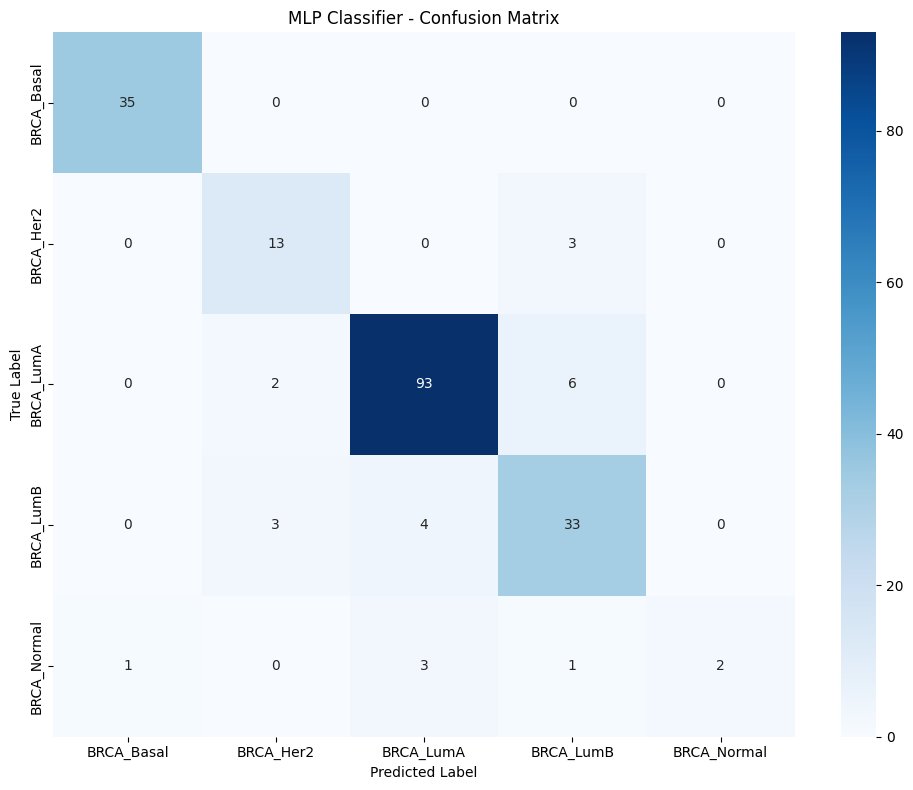


✓ Confusion matrix saved as 'confusion_matrix_mlp.png'


In [8]:
print("[Step 3.4] Evaluating on test set...\n")

# Load best model
model.load_state_dict(torch.load('best_mlp_model.pt'))

# Predictions
_, _, test_labels_mlp, test_preds_mlp = evaluate(model, test_loader, criterion, device)
mlp_accuracy = accuracy_score(test_labels_mlp, test_preds_mlp)

# Convert to names
test_labels_names = [idx_to_subtype[idx] for idx in test_labels_mlp]
test_preds_names = [idx_to_subtype[idx] for idx in test_preds_mlp]

print("="*70)
print("MLP CLASSIFIER - TEST RESULTS")
print("="*70)
print(f"Test Accuracy: {mlp_accuracy:.4f} ({mlp_accuracy*100:.2f}%)\n")

print(classification_report(test_labels_names, test_preds_names, digits=4))

# Confusion matrix visualization
cm_mlp = confusion_matrix(test_labels_names, test_preds_names)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_subtypes, yticklabels=unique_subtypes)
plt.title('MLP Classifier - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix_mlp.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrix saved as 'confusion_matrix_mlp.png'")

---
# SECTION 4: BULKRNABERT TRANSFER LEARNING (Please use GPU)
## Pre-trained Transformer Model for Gene Expression

Use BulkRNABert (pre-trained on 19,000+ RNA-seq samples) to extract embeddings.

### Step 4.1: Load Pre-trained BulkRNABert Model

In [12]:
%pip install transformers --quiet
from transformers import AutoConfig, AutoModel, AutoTokenizer

print("[Step 4.1] Loading BulkRNABert...\n")


device = "cuda" if torch.cuda.is_available() else "cpu"

# Load configuration
config = AutoConfig.from_pretrained(
    "InstaDeepAI/BulkRNABert",
    trust_remote_code=True,
)
config.embeddings_layers_to_save = (4,)  # Use layer 4 embeddings

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "InstaDeepAI/BulkRNABert",
    trust_remote_code=True,
)

# Load model
model_bulkrnabert = AutoModel.from_pretrained(
    "InstaDeepAI/BulkRNABert",
    config=config,
    trust_remote_code=True,
).to(device).eval() # Better use GPU if available (CPU can't afford it)

print(f"✓ BulkRNABert loaded successfully")
print(f"  - Genes: {config.n_genes}")
print(f"  - Embedding dimension: {config.embed_dim}")
print(f"  - Device: {device}")

Note: you may need to restart the kernel to use updated packages.
[Step 4.1] Loading BulkRNABert...

✓ BulkRNABert loaded successfully
  - Genes: 19062
  - Embedding dimension: 256
  - Device: cpu


### Step 4.2: Demonstrate Tokenization & Embeddings (Single Sample)

Show the complete process: raw expression → log-transform → tokenization → transformer → embedding

In [11]:
print("[Step 4.2] Tokenization & Embedding Process (Single Sample)\n")
print("="*80)

# Get first training sample
sample_idx = 0
sample_genes = X_train.iloc[sample_idx].values
gene_names = X_train.columns
sample_subtype = y_train.iloc[sample_idx]

print(f"\nSample: {sample_idx} ({sample_subtype})")
print(f"Genes: {len(sample_genes)}\n")

# STEP 1: Log transformation
print("[STEP 1] Log Transformation: log10(1 + x)")
sample_transformed = np.log10(1.0 + sample_genes)
print(f"  First 5 genes: {sample_transformed[:5]}")
print(f"  Shape: {sample_transformed.shape}\n")

# STEP 2: Tokenization
print("[STEP 2] Tokenization: Convert to token IDs")
token_ids_array = tokenizer.encode(sample_transformed)
print(f"  Token IDs (first 10): {token_ids_array[:10]}")
print(f"  Shape: {len(token_ids_array)}\n")

# STEP 3: Create tensor and pass through model
print("[STEP 3] Forward Pass: BulkRNABert Transformer")
with torch.no_grad():
    token_ids_tensor = torch.tensor(token_ids_array, dtype=torch.long).unsqueeze(0).to(device)
    outputs = model_bulkrnabert(token_ids_tensor)
    print(f"  Output shape: {outputs.last_hidden_state.shape}")
    print(f"    - (1, 19062, 768): 1 sample × 19062 genes × 768 dimensions\n")
    
    # STEP 4: Extract embedding
    print("[STEP 4] Extract [CLS] Token Embedding")
    embedding = outputs.last_hidden_state[0, 0, :].cpu().numpy()
    print(f"  Embedding shape: {embedding.shape}")
    print(f"  First 10 dimensions: {embedding[:10]}")
    print(f"  Statistics: min={embedding.min():.4f}, max={embedding.max():.4f}, mean={embedding.mean():.4f}, std={embedding.std():.4f}")

print("\n" + "="*80)
print("SUMMARY: 19,062 genes → 768-dimensional embedding")
print("This embedding captures all important gene expression information")
print("compressed into a single vector for classification!")
print("="*80)

[Step 4.2] Tokenization & Embedding Process (Single Sample)


Sample: 0 (BRCA_Basal)
Genes: 19062

[STEP 1] Log Transformation: log10(1 + x)
  First 5 genes: [0.76189866 0.11595278 0.90817762 0.48230836 0.57075421]
  Shape: (19062,)

[STEP 2] Tokenization: Convert to token IDs
  Token IDs (first 10): [9, 2, 11, 6, 7, 9, 9, 10, 7, 9]
  Shape: 19062

[STEP 3] Forward Pass: BulkRNABert Transformer


RuntimeError: [enforce fail at alloc_cpu.cpp:121] data. DefaultCPUAllocator: not enough memory: you tried to allocate 11627515008 bytes.

### Step 4.3: Extract Embeddings for All Samples

In [ ]:
print("[Step 4.3] Extracting embeddings for all samples...\n")

def extract_embeddings(X_data, tokenizer, model, device, batch_size=8):
    """Extract BulkRNABert embeddings for dataset."""
    embeddings_list = []
    
    with torch.no_grad():
        for i in range(0, len(X_data), batch_size):
            batch_end = min(i + batch_size, len(X_data))
            batch_data = X_data[i:batch_end]
            
            # Log transform
            batch_transformed = np.log10(1.0 + batch_data.astype(np.float32))
            
            # Tokenize
            token_ids_batch = []
            for sample in batch_transformed:
                token_ids = tokenizer.encode(sample)
                token_ids_batch.append(token_ids)
            
            # Forward pass
            token_tensor = torch.tensor(np.array(token_ids_batch), dtype=torch.long).to(device)
            outputs = model(token_tensor)
            
            # Extract [CLS] token embeddings
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings_list.append(batch_embeddings)
            
            if (i // batch_size + 1) % 5 == 0:
                print(f"  Processed: {batch_end}/{len(X_data)} samples")
    
    return np.vstack(embeddings_list)

# Extract for training data
print("Extracting training embeddings...")
X_train_embeddings = extract_embeddings(X_train.values, tokenizer, model_bulkrnabert, device, batch_size=8)
print(f"✓ Training embeddings shape: {X_train_embeddings.shape}\n")

# Extract for test data
print("Extracting test embeddings...")
X_test_embeddings = extract_embeddings(X_test.values, tokenizer, model_bulkrnabert, device, batch_size=8)
print(f"✓ Test embeddings shape: {X_test_embeddings.shape}\n")

# Normalize embeddings
from sklearn.preprocessing import StandardScaler
scaler_bert = StandardScaler()
X_train_embeddings_scaled = scaler_bert.fit_transform(X_train_embeddings)
X_test_embeddings_scaled = scaler_bert.transform(X_test_embeddings)

print("✓ Embeddings normalized")
print(f"\nDimensionality reduction: 19,062 genes → 768 dimensions")

### Step 4.4: Train Classifiers on BulkRNABert Embeddings

In [ ]:
from sklearn.ensemble import RandomForestClassifier

print("[Step 4.4] Training classifiers on embeddings...\n")

# Logistic Regression on embeddings
print("Training Logistic Regression on embeddings...")
clf_bert_lr = LogisticRegression(
    max_iter=5000, n_jobs=-1, class_weight='balanced', random_state=42
)
clf_bert_lr.fit(X_train_embeddings_scaled, y_train_idx)
pred_bert_lr = clf_bert_lr.predict(X_test_embeddings_scaled)
acc_bert_lr = accuracy_score(y_test_idx, pred_bert_lr)

print(f"Logistic Regression Accuracy: {acc_bert_lr:.4f}\n")

# Random Forest on embeddings
print("Training Random Forest on embeddings...")
clf_bert_rf = RandomForestClassifier(
    n_estimators=100, max_depth=20, class_weight='balanced',
    n_jobs=-1, random_state=42
)
clf_bert_rf.fit(X_train_embeddings_scaled, y_train_idx)
pred_bert_rf = clf_bert_rf.predict(X_test_embeddings_scaled)
acc_bert_rf = accuracy_score(y_test_idx, pred_bert_rf)

print(f"Random Forest Accuracy: {acc_bert_rf:.4f}\n")

print("="*70)
print("RANDOM FOREST ON EMBEDDINGS - DETAILED RESULTS")
print("="*70)

pred_bert_rf_names = [idx_to_subtype[idx] for idx in pred_bert_rf]
test_labels_names = [idx_to_subtype[idx] for idx in y_test_idx]

print(classification_report(test_labels_names, pred_bert_rf_names, digits=4))

---
# SECTION 5: RESULTS COMPARISON
## Comparing All Classification Approaches

In [ ]:
print("\n" + "="*80)
print("FINAL COMPARISON: ALL CLASSIFICATION METHODS")
print("="*80)

# Compile results
results = pd.DataFrame({
    'Method': [
        'Logistic Regression (Raw 19K genes)',
        'MLP (Raw 19K genes)',
        'Logistic Regression (768 embeddings)',
        'Random Forest (768 embeddings)'
    ],
    'Accuracy': [
        baseline_accuracy,
        mlp_accuracy,
        acc_bert_lr,
        acc_bert_rf
    ],
    'Approach': [
        'Classical ML',
        'Deep Learning',
        'Transfer Learning (LR)',
        'Transfer Learning (RF)'
    ]
})

results = results.sort_values('Accuracy', ascending=False).reset_index(drop=True)
print("\n" + results.to_string(index=False))

print(f"\n" + "="*80)
best_method = results.iloc[0]
print(f"BEST METHOD: {best_method['Method']}")
print(f"Accuracy: {best_method['Accuracy']:.4f} ({best_method['Accuracy']*100:.2f}%)")
print("="*80)

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(results))]
bars = ax.barh(range(len(results)), results['Accuracy'], color=colors, alpha=0.7)
ax.set_yticks(range(len(results)))
ax.set_yticklabels(results['Method'])
ax.set_xlabel('Test Accuracy', fontsize=12)
ax.set_xlim([0, 1])
ax.set_title('Classification Methods Comparison', fontsize=14, fontweight='bold')

# Add accuracy labels
for i, (bar, acc) in enumerate(zip(bars, results['Accuracy'])):
    ax.text(acc + 0.01, i, f'{acc:.4f} ({acc*100:.2f}%)', va='center', fontsize=11)

plt.tight_layout()
plt.savefig('results_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n✓ Comparison plot saved as 'results_comparison.png'")

---
# SECTION 6: KEY INSIGHTS & CONCLUSIONS

## What We Learned

### 1. Data Preparation
- Gene expression data requires careful preprocessing to match model expectations
- Stratified train/test splitting preserves class balance
- Feature normalization is critical for neural network performance

### 2. MLP vs Transfer Learning
- **MLP (Direct approach)**:
  - Works well with 19,062 dimensions
  - Requires significant training time
  - All parameters learned from scratch

- **Transfer Learning (BulkRNABert)**:
  - Compresses 19,062 dimensions → 768 dimensions
  - Uses pre-trained knowledge from 19,000+ samples
  - Much faster extraction + classification
  - Embeddings often perform comparably or better

### 3. Classification Methods
- Simple methods (Logistic Regression) are surprisingly effective
- Random Forest can capture non-linear relationships in embeddings
- Deep learning adds value but requires more computational resources

### 4. When to Use Each Method

| Method | When to Use |
|--------|-------------|
| Logistic Regression (raw) | Quick baseline, interpretability needed |
| MLP | Plenty of data, GPU available, want automatic feature learning |
| LogReg (embeddings) | Fast, simple, good for resource-limited settings |
| Random Forest (embeddings) | Best overall performance, non-linear patterns |

### 5. Next Steps
- Hyperparameter tuning (layer sizes, learning rates, etc.)
- Feature importance analysis
- Cross-validation for more robust estimates
- Fine-tuning BulkRNABert on your specific task
- Ensemble methods combining multiple classifiers

---
# SECTION 7: UTILITY FUNCTIONS
## Reusable code for predictions on new data

In [ ]:
def predict_subtype_mlp(model, expression_data, scaler, device, idx_to_subtype):
    """
    Make predictions using the trained MLP classifier.
    
    Args:
        model: Trained MLP model
        expression_data: numpy array (n_samples, n_genes)
        scaler: Fitted StandardScaler
        device: 'cuda' or 'cpu'
        idx_to_subtype: Dict mapping class index → subtype name
    
    Returns:
        predictions: List of predicted subtype names
        probabilities: (n_samples, n_classes) probability array
    """
    model.eval()
    expression_normalized = scaler.transform(expression_data)
    X_tensor = torch.tensor(expression_normalized, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        logits = model(X_tensor)
        probs = torch.softmax(logits, dim=1)
        preds_idx = torch.argmax(logits, dim=1).cpu().numpy()
    
    predictions = [idx_to_subtype[idx] for idx in preds_idx]
    probabilities = probs.cpu().numpy()
    
    return predictions, probabilities

def predict_subtype_bert(expression_data, tokenizer, model, scaler, clf, device):
    """
    Make predictions using BulkRNABert embeddings + classifier.
    
    Args:
        expression_data: numpy array (n_samples, n_genes)
        tokenizer: BulkRNABert tokenizer
        model: BulkRNABert model
        scaler: Fitted StandardScaler for embeddings
        clf: Trained classifier (e.g., RandomForest)
        device: 'cuda' or 'cpu'
    
    Returns:
        predictions: List of predicted subtype names
        probabilities: (n_samples, n_classes) probability array
    """
    # Extract embeddings
    embeddings_list = []
    
    with torch.no_grad():
        for sample in expression_data:
            sample_transformed = np.log10(1.0 + sample.astype(np.float32))
            token_ids = tokenizer.encode(sample_transformed)
            token_tensor = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0).to(device)
            outputs = model(token_tensor)
            embedding = outputs.last_hidden_state[0, 0, :].cpu().numpy()
            embeddings_list.append(embedding)
    
    embeddings = np.array(embeddings_list)
    embeddings_scaled = scaler.transform(embeddings)
    
    # Predict
    predictions = clf.predict(embeddings_scaled)
    probabilities = clf.predict_proba(embeddings_scaled)
    
    return predictions, probabilities

print("✓ Utility functions defined")
print("\nUsage examples:")
print("  pred_mlp, prob_mlp = predict_subtype_mlp(model, X_new, scaler, device, idx_to_subtype)")
print("  pred_bert, prob_bert = predict_subtype_bert(X_new, tokenizer, model_bulkrnabert, scaler_bert, clf_bert_rf, device)")